In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Use 20% of the images as validation data
)

# Assuming your 'letters' folder has subfolders named 'A', 'B', ..., 'Z', '0', '1', ..., '9'
train_generator = train_datagen.flow_from_directory(
    'supervisedLetters',
    target_size=(34, 80),  # Resize images to 224x224
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Specify this is training data
)

validation_generator = train_datagen.flow_from_directory(
    'supervisedLetters',
    target_size=(34, 80),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Specify this is validation data
)


Found 493 images belonging to 36 classes.


Found 107 images belonging to 36 classes.


In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

# Load the pre-trained ResNet50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(34, 80, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add new layers for your specific classification task
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(36, activation='relu')(x)  # 36 classes: A-Z, 0-9

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])


In [22]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)


Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.0438 - loss: 13.0327 - val_accuracy: 0.0521 - val_loss: 12.8847
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.0000e+00 - loss: 6.5039 - val_accuracy: 0.0000e+00 - val_loss: 5.5317
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.0480 - loss: 12.7372 - val_accuracy: 0.0417 - val_loss: 12.8927
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.0000e+00 - loss: 6.2679 - val_accuracy: 0.0909 - val_loss: 5.4984
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.0416 - loss: 12.8993 - val_accuracy: 0.0521 - val_loss: 12.8945
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.0312 - loss: 6.0192 - val_accuracy: 0.0000e+00 - val_loss: 5.4918
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.0422 - loss: 13.2437 - val_accuracy: 0.0521 - val_loss: 12.5977
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.0625 - loss: 6.2452 - val_

In [11]:
def predict_image(img_path, label_map):
    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)  # Convert the image to NumPy array
    img_tensor = np.expand_dims(img_tensor, axis=0)  # Add batch dimension
    img_tensor /= 255.0  # Normalize the image

    prediction = model.predict(img_tensor)
    class_index = np.argmax(prediction)  # Index of the highest probability class
    class_label = [key for key, value in label_map.items() if value == class_index][0]
    return class_label

label_map = (train_generator.class_indices)
print(label_map)

# Assuming you've already loaded your model and have the label_map
new_image_path = r'letters\ALKOMLLAH_5.png'
predicted_class_label = predict_image(new_image_path, label_map)
print("Predicted class label:", predicted_class_label)


{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15, 'g': 16, 'h': 17, 'i': 18, 'j': 19, 'k': 20, 'l': 21, 'm': 22, 'n': 23, 'o': 24, 'p': 25, 'q': 26, 'r': 27, 's': 28, 't': 29, 'u': 30, 'v': 31, 'w': 32, 'x': 33, 'y': 34, 'z': 35}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Predicted class label: 5


In [23]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define constants and parameters
DATA_DIR = 'supervisedLetters'
TARGET_SIZE = (34, 80)
BATCH_SIZE = 32
NUM_CLASSES = 36  # A-Z and 0-9

# Setup ImageDataGenerators for Training and Validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Load and customize the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Create and compile the final model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)

# Evaluate the model
eval_result = model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print(f"Validation Loss: {eval_result[0]}, Validation Accuracy: {eval_result[1]}")

Found 493 images belonging to 36 classes.
Found 107 images belonging to 36 classes.
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.0089 - loss: 3.6981 - val_accuracy: 0.0417 - val_loss: 3.5597
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.0000e+00 - loss: 1.9405 - val_accuracy: 0.0909 - val_loss: 1.7305
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.0375 - loss: 3.5523 - val_accuracy: 0.0729 - val_loss: 3.5267
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.0625 - loss: 1.9345 - val_accuracy: 0.0000e+00 - val_loss: 1.7902
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.0552 - loss: 3.5302 - val_accuracy: 0.0625 - val_loss: 3.5133
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.0312 - loss: 1.9096 - val_accuracy: 0.0000e+00 - val_loss: 1.7461
Epoch 7/10


KeyboardInterrupt: 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 55, 55, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 27, 27, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 13, 13, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 13, 13, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 13, 13, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4096)           │    37,752,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 36)             │       147,492 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,428,836 (222.89 MB)

 Trainable params: 58,428,836 (222.89 MB)

 Non-trainable params: 0 (0.00 B)

Found 493 images belonging to 36 classes.
Found 107 images belonging to 36 classes.
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.0265 - loss: 9.8389 - val_accuracy: 0.0374 - val_loss: 3.5827
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.0374 - loss: 3.5820 - val_accuracy: 0.0374 - val_loss: 3.5701
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.0391 - loss: 3.5730 - val_accuracy: 0.0374 - val_loss: 3.5630
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.0300 - loss: 3.5704 - val_accuracy: 0.0374 - val_loss: 

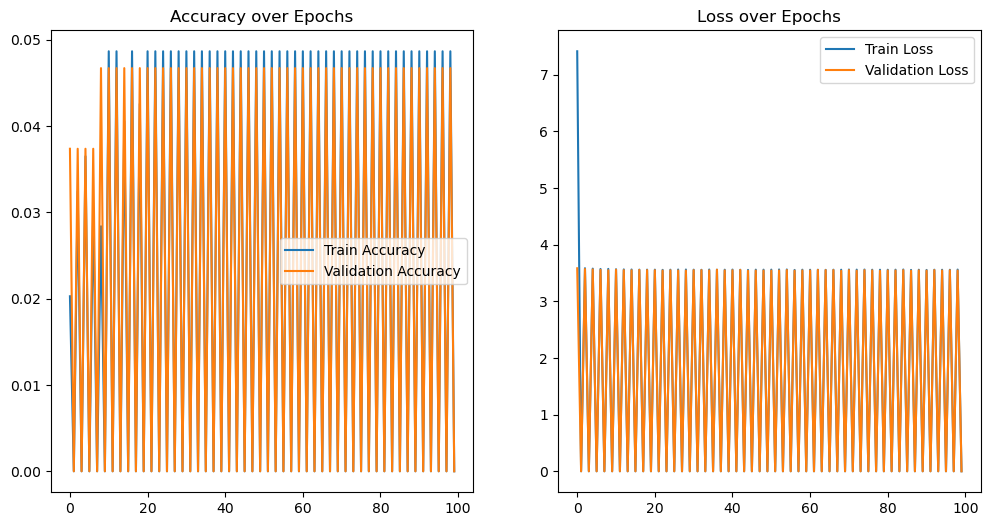

In [26]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Constants
DATA_DIR = 'supervisedLetters'
TARGET_SIZE = (34, 80)  # Adjusted to AlexNet input size
BATCH_SIZE = 64
N_CLASSES = 36  # Assuming 26 letters and 10 digits
EPOCHS = 100

# Define AlexNet-like model
def alex_net(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(96, 11, strides=4, activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(3, strides=2),
        layers.Conv2D(256, 5, padding='same', activation='relu'),
        layers.MaxPooling2D(3, strides=2),
        layers.Conv2D(384, 3, padding='same', activation='relu'),
        layers.Conv2D(384, 3, padding='same', activation='relu'),
        layers.Conv2D(256, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(3, strides=2),
        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Data generator function
def data_generator(data_dir, batch_size, is_training):
    gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2
    )
    if is_training:
        generator = gen.flow_from_directory(
            data_dir,
            target_size=TARGET_SIZE,
            batch_size=batch_size,
            class_mode='categorical',
            subset='training'
        )
    else:
        generator = gen.flow_from_directory(
            data_dir,
            target_size=TARGET_SIZE,
            batch_size=batch_size,
            class_mode='categorical',
            subset='validation'
        )
    return generator

# Setup model
model = alex_net(TARGET_SIZE + (3,), N_CLASSES)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Prepare data
train_gen = data_generator(DATA_DIR, BATCH_SIZE, True)
val_gen = data_generator(DATA_DIR, BATCH_SIZE, False)

# Training
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=len(val_gen)
)

# Evaluation
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

# Test with individual images or further analysis


In [30]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

def create_datagen():
    train_datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2  # Using 20% of the data for validation
    )
    return train_datagen

def create_generators(base_dir, input_shape, batch_size):
    datagen = create_datagen()
    
    train_generator = datagen.flow_from_directory(
        base_dir,  # Directly use base_dir without '/train'
        target_size=input_shape,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )
    validation_generator = datagen.flow_from_directory(
        base_dir,  # Same here, use base_dir
        target_size=input_shape,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )
    return train_generator, validation_generator



def define_model(num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(34, 80, 3)),  # Adjusted input_shape
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'),
        Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(100, activation='relu', kernel_initializer='he_uniform'),
        Dense(num_classes, activation='softmax')
    ])
    # compile model
    opt = SGD(learning_rate=0.001, momentum=0.01)  # Changed 'lr' to 'learning_rate'
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model



# Define parameters
base_dir = 'supervisedLetters'
input_shape = (34, 80)  # Adjust based on your dataset
batch_size = 16
num_classes = 36  # Update this based on your actual class count

# Prepare data generators
train_gen, val_gen = create_generators(base_dir, input_shape, batch_size)
print(train_gen.class_indices)

# Define the model
model = define_model(num_classes)

# Directory to save the models
model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Create a checkpoint callback to save best model each epoch with a unique name
checkpoint_cb = ModelCheckpoint(
    os.path.join(model_dir, 'model_epoch_{epoch:02d}_loss_{val_loss:.8f}.keras'),
    save_best_only=False,  # Change this to False to save models at each epoch regardless of validation loss
    monitor='val_loss',  # Decide what to monitor; here we use validation loss
    mode='min',  # Save models with the minimum validation loss
    verbose=1  # Print out messages when saving models
)

# Fit model
model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    validation_data=val_gen,
    validation_steps=len(val_gen),
    epochs=1000,
    callbacks=[checkpoint_cb]
)


Found 6085 images belonging to 36 classes.
Found 1503 images belonging to 36 classes.
{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15, 'g': 16, 'h': 17, 'i': 18, 'j': 19, 'k': 20, 'l': 21, 'm': 22, 'n': 23, 'o': 24, 'p': 25, 'q': 26, 'r': 27, 's': 28, 't': 29, 'u': 30, 'v': 31, 'w': 32, 'x': 33, 'y': 34, 'z': 35}
Epoch 1/1000
378/381 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0351 - loss: 3.6237
Epoch 1: saving model to models\model_epoch_01_loss_3.58627963.keras
381/381 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.0351 - loss: 3.6234 - val_accuracy: 0.0259 - val_loss: 3.5863
Epoch 2/1000

Epoch 2: saving model to models\model_epoch_02_loss_0.00000000.keras
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/1000
380/381 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.0292 - loss: 3.5817
Epoch 3: saving

In [29]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os
import shutil

# Load the saved model
model = load_model(r'modelsFinal\model_epoch_1000_loss_0.00.keras')

def load_and_prepare_image(filepath, target_size):
    # Load the image file, resizing it to match the input shape expected by the model
    img = load_img(filepath, target_size=target_size)
    # Convert the image to a numpy array
    img_array = img_to_array(img)
    # Normalize the image in the same way we did during training
    img_array /= 255.0
    # Expand dimensions to represent a single image batch
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def classify_and_move_images(source_dir, target_dir, model, target_size):
    for subdir, dirs, files in os.walk(source_dir):
        for file in files:
            filepath = os.path.join(subdir, file)
            try:
                img = load_and_prepare_image(filepath, target_size)
                prediction = model.predict(img)
                predicted_class_index = np.argmax(prediction, axis=1)

                new_dir = os.path.join(target_dir, str(predicted_class_index))
                if not os.path.exists(new_dir):
                    os.makedirs(new_dir)

                shutil.copy(filepath, new_dir)
                print(f"Copied {file} to {new_dir}")

            except Exception as e:
                print(f"Failed to process {file}: {str(e)}")

# Example usage
source_directory = r'letters'  # path to the 'letters' folder
target_directory = r'letters/let'  # path to the new folder structure

classify_and_move_images(source_directory, target_directory, model, target_size=(34, 80))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Copied AAIHTXKVJ_0.png to letters/let\[29]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Copied AAIHTXKVJ_1.png to letters/let\[8]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Copied AAIHTXKVJ_2.png to letters/let\[29]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Copied AAIHTXKVJ_3.png to letters/let\[17]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Copied AAIHTXKVJ_4.png to letters/let\[31]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Copied AAIHTXKVJ_5.png to letters/let\[22]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Copied ADBPLHDOH_0.png to letters/let\[29]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Copied ADBPLHDOH_1.png to letters/let\[18]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Copied ADBPLHDOH_2.png to letters/let\[1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Copied ADBPLHDOH_3.png to letters/let\[3]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Copied ADBPLHDOH_4.png to letters/let\[17]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Copied ADBPLHDOH_5.png to letters/let\[6]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms

In [27]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import numpy as np

# Assuming the model and load_and_prepare_image function are already defined/imported

def load_and_prepare_image(filepath, target_size):
    img = load_img(filepath, target_size=target_size)
    img_array = img_to_array(img)
    img_array /= 255.0  # Rescale the same as during training
    img_array = np.expand_dims(img_array, axis=0)  # Make it batch-like
    return img_array

# Load the trained model
model = load_model('modelsFinal\model_epoch_110_loss_0.00.keras')

# Path to the image you want to predict
image_path = r'supervisedLetters\0\3qtq0i_4.png'
target_size = (34, 80)  # Must match the input shape the model was trained with

# Prepare the image
prepared_image = load_and_prepare_image(image_path, target_size)

# Predict the probabilities
probabilities = model.predict(prepared_image)

# Assuming the training generator is available or you know the class labels
class_labels = train_gen.class_indices
class_labels = dict((v,k) for k,v in class_labels.items())  # Reversing key and values

# Print probabilities for each class
print("Probabilities for each class:")
for index, prob in enumerate(probabilities[0]):
    print(f"{class_labels[index]}: {prob:.4f}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Probabilities for each class:
0: 0.1932
1: 0.0000
2: 0.0000
3: 0.0000
4: 0.0000
5: 0.0001
6: 0.7738
7: 0.0000
8: 0.0000
9: 0.0321
a: 0.0000
b: 0.0005
c: 0.0000
d: 0.0000
e: 0.0000
f: 0.0000
g: 0.0000
h: 0.0000
i: 0.0000
j: 0.0000
k: 0.0000
l: 0.0000
m: 0.0000
n: 0.0000
o: 0.0003
p: 0.0000
q: 0.0000
r: 0.0000
s: 0.0000
t: 0.0000
u: 0.0000
v: 0.0000
w: 0.0000
x: 0.0000
y: 0.0000
z: 0.0000
